# Tracking useful datasets

1. Start
    1. train_base
    1. census_data
2. Preprocessing
    1. train_base
    1. thin_census_data (converted form of census for join)
    

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
# Installation of libraries as required

!pip install sklearn

# Importing libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define custom functions or classes

In [4]:
# None required right now

# Pre-Processing data

1. Import the dataset
2. Generate high level summaries and pair plots

## Import data

In [5]:
train_base = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
census_data = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample_submission = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

train_base.head(5)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [6]:
census_data.head(5)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [7]:
sample_submission.head(5)

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


#### Notes:

1. Additional census attributes need to be mapped through cfips attribute
2. Census data needs to be transformed into a thin format for usablity and joins
3. Census data is yearly, whereas the microbusiness data is monthly. We will need to keep this in ming when modelling later
4. Final submission needs a key based on cfips and date combination. Thus we will be working with 2 sets of keys to join and model data.
    1. cfips + full date
    2. cfips + year (for joining census data)

## Basic summary
We will try and understand the type of data we will work with

In [8]:
train_base.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,1.222650e+05
mean,30376.037640,3.817671,6.442858e+03
std,15143.508721,4.991087,3.304001e+04
min,1001.000000,0.000000,0.000000e+00
25%,18177.000000,1.639344,1.450000e+02
50%,29173.000000,2.586543,4.880000e+02
75%,45077.000000,4.519231,2.124000e+03
max,56045.000000,284.340030,1.167744e+06


In [9]:
train_base.isnull().any()

row_id                   False
cfips                    False
county                   False
state                    False
first_day_of_month       False
microbusiness_density    False
active                   False
dtype: bool

In [10]:
train_base.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [11]:
census_data.isnull().sum(axis = 0)

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

## Pre-processing

1. Convert census data into thin format
1. Fill in the missing data in census data
1. Add relevant keys to census and train data
1. Validate if all keys are present in both datasets (helps determine potential upcoming missing values in data)

We may need to perform additional processing based on the validation results

### Transform census data

In [12]:
census_data_cols = census_data.columns.values

# We will use "_" to seperate each string and create a new thin dataframe
# This dataframe will be at a "cfips" and "year" level to enable join with the base dataset

temp = pd.DataFrame(census_data_cols, index= None)

temp.rename(columns = {0:"col_name"}, inplace = True)

# Remove cfips to make life easy

temp = temp.loc[temp['col_name'] != "cfips",:]

temp['year'] = temp['col_name'].str.slice(-4).astype('int')
temp['temp'] = "_"+temp['year'].astype('str')

#temp['new_col_name'] = temp['col_name'].str.replace(temp['temp'], "")
# Since expected method does not work, we will remove the last 5 characters for ease

temp['new_col_name'] = temp['col_name'].str.slice(start = 0, stop = -5).astype('str')

temp.drop(columns = ("temp"), inplace = True)
temp

,col_name,year,new_col_name
0,pct_bb_2017,2017,pct_bb
1,pct_bb_2018,2018,pct_bb
2,pct_bb_2019,2019,pct_bb
3,pct_bb_2020,2020,pct_bb
4,pct_bb_2021,2021,pct_bb
6,pct_college_2017,2017,pct_college
7,pct_college_2018,2018,pct_college
8,pct_college_2019,2019,pct_college
9,pct_college_2020,2020,pct_college
10,pct_college_2021,2021,pct_college


#### Convert census to thin format

We will run a loop to iterate through our gegerated columns, and append data to empty dataframe
We will summarize the dataframe to make format consistent without loss of data
Hopefully there is a better way to do this

In [13]:
new_cols = list(temp['new_col_name'].unique())

# Add the year and cfips columns 
new_cols.insert(0, ("year"))
new_cols.insert(0, ("cfips"))

# Make empty dataframe
thin_census_data = pd.DataFrame(columns = new_cols)

# Generate all possible combinations of cfips and year from just census data

for row in temp.itertuples():
    col_name = row.col_name
    year = row.year
    new_col_name = row.new_col_name
    
    # Make data to append/join
    temp_data = census_data.loc[:,("cfips",col_name)]# Get the required column along with IDs
    temp_data["year"] = year # Add year column
    
    temp_data = temp_data.loc[:,("cfips","year",col_name)] # Reorder columns for consistency
    temp_data.rename(columns = {col_name:new_col_name}, inplace = True)
    
    # Append data to out main dataframe
    thin_census_data = pd.concat((thin_census_data,temp_data), axis = 0)


# Summarize the dataset to get the final 
thin_census_data = thin_census_data.groupby(by = ["cfips","year"], as_index = False).first().reset_index()
thin_census_data.drop(columns = 'index', inplace = True)

thin_census_data.tail()

,cfips,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
15705,56045,2017,71.1,14.1,3.8,0.6,59605.0
15706,56045,2018,73.3,13.5,4.1,0.6,52867.0
15707,56045,2019,76.8,13.4,1.7,0.0,57031.0
15708,56045,2020,79.7,12.7,2.3,0.0,53333.0
15709,56045,2021,81.3,13.9,1.6,0.0,65566.0


#### Validate the transformed dataset

We will check if everything went smoothly using simple summaries across original and converted dataset

In [14]:
# Original summary
census_data.describe()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3142.000000,3141.000000,...,3142.000000,3141.000000,3142.000000,3141.000000,3141.000000,3142.000000,3141.000000,3142.000000,3140.000000,3140.000000
mean,69.920401,72.690866,75.398600,78.543298,80.539096,30383.649268,13.813399,14.005379,14.240452,14.631328,...,1.427148,1.382171,1.338956,1.309265,1.272684,49754.163908,51583.175422,53475.909612,55012.443312,58223.339490
std,9.702052,9.255863,8.846665,8.250864,7.889931,15162.508374,5.586649,5.630199,5.689780,5.776940,...,0.986985,0.942777,0.940891,0.990342,0.968579,13154.424871,13703.502202,14192.529173,14649.568591,15541.038914
min,24.500000,25.700000,34.800000,33.300000,37.000000,1001.000000,2.400000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000
25%,64.200000,67.425000,70.500000,74.100000,76.400000,18177.500000,9.700000,9.900000,10.100000,10.500000,...,0.800000,0.800000,0.700000,0.700000,0.600000,41123.000000,42480.000000,44155.000000,45653.000000,48179.500000
50%,70.700000,73.600000,76.450000,79.600000,81.700000,29176.000000,12.800000,13.000000,13.250000,13.600000,...,1.300000,1.300000,1.200000,1.200000,1.100000,48065.500000,49888.000000,51757.500000,52842.000000,55907.000000
75%,76.400000,78.800000,81.400000,84.100000,85.900000,45080.500000,16.800000,17.100000,17.300000,17.900000,...,1.900000,1.800000,1.800000,1.800000,1.700000,55763.500000,57611.000000,59867.250000,61500.750000,64930.000000
max,94.600000,95.500000,96.000000,97.100000,97.600000,56045.000000,43.700000,48.000000,45.400000,43.000000,...,17.400000,11.700000,10.500000,15.200000,15.200000,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000


In [15]:
thin_census_data.groupby(by = ['year']).min()
thin_census_data.groupby(by = ['year']).max()

,cfips,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
year,,,,,,
2017,56045,94.6,43.7,52.9,17.4,129588.0
2018,56045,95.5,48.0,53.3,11.7,136268.0
2019,56045,96.0,45.4,53.7,10.5,142299.0
2020,56045,97.1,43.0,54.0,15.2,147111.0
2021,56045,97.6,43.7,54.0,15.2,156821.0


### Process the train dataset

We will extract relevant information from the dataset and join the census data to make the final dataset

1. Extract the year and month out of the date columns
2. Reorder columns for ease of reading

In [16]:
train_base.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [17]:
# Extract the year from dates
train_base['first_day_of_month'] = pd.to_datetime(train_base['first_day_of_month'])

# Extracting important numbers from date
train_base['year'] = train_base['first_day_of_month'].dt.year
train_base['month'] = train_base['first_day_of_month'].dt.month

# Reorder columns
reorder_cols = ('row_id', 'cfips', 'year', 'month', 'first_day_of_month', 'county', 'state', 'active', 'microbusiness_density')
train_base = train_base.loc[:,reorder_cols]

train_base.head()

,row_id,cfips,year,month,first_day_of_month,county,state,active,microbusiness_density
0,1001_2019-08-01,1001,2019,8,2019-08-01,Autauga County,Alabama,1249,3.007682
1,1001_2019-09-01,1001,2019,9,2019-09-01,Autauga County,Alabama,1198,2.884870
2,1001_2019-10-01,1001,2019,10,2019-10-01,Autauga County,Alabama,1269,3.055843
3,1001_2019-11-01,1001,2019,11,2019-11-01,Autauga County,Alabama,1243,2.993233
4,1001_2019-12-01,1001,2019,12,2019-12-01,Autauga County,Alabama,1243,2.993233


## Cross-Validate both datasets

1. We will check if we have match for all (or most) keys in dataset

Observations:
1. Census data has extra counties included
1. Census data is not available for 2022 (which is logical).
    1. THus we may need to generate some projecttions/estimates for 2022. We can either use same 2021 numbers or determine average growth rate based on bucketed counties


In [25]:
train_cfips = train_base['cfips'].unique()
train_years = train_base['year'].unique()

census_cfips = thin_census_data['cfips'].unique()
census_years = thin_census_data['year'].unique()

#### Check county IDs

In [32]:
print("Training data")
print(train_cfips)
print("size = ",train_cfips.shape)

print("\nCensus Data")
print(census_cfips)
print("size = ",census_cfips.shape)

# Print missing from each sets
print("Missing from census data (but are present in training data):")
print(train_cfips[~np.in1d(train_cfips, census_cfips)])

print("Missing from training data (and are available in census):")
print(census_cfips[~np.in1d(census_cfips, train_cfips)])

Training data
[ 1001  1003  1005 ... 56041 56043 56045]
size =  (3135,)

Census Data
[ 1001  1003  1005 ... 56041 56043 56045]
size =  (3142,)


#### Check years

In [44]:
print("Training data")
print(train_years)
print("size = ",train_years.shape)

print("\nCensus Data")
print(census_years)
print("size = ",census_years.shape)

# Print missing from each sets
print("Missing from census data (but are present in training data):")
print(train_years[~np.in1d(train_years, census_years)])

print("Missing from training data (and are available in census):")
print(census_years[~np.in1d(census_years, train_years)])

Training data
[2019 2020 2021 2022]
size =  (4,)

Census Data
[2017 2018 2019 2020 2021]
size =  (5,)
Missing from census data (but are present in training data):
[2022]
Missing from training data (and are available in census):
[2017 2018]


# EDA

As we have some relevant information on the data, we can perform EDA to establish a high level understanding before proceeding.

## Training data

Visualize the timeline using line charts

### Microbusiness density over time

Since we have few counties doing cnonsiderably better than others (again expected information), we may need to bucket counties into groups for easy managable visualizations

In [ ]:
# Bucket Counties based on micro density variable

eda_train_data = train_base

eda_train_data['cfip_buckets'] = eda_train_data['microbusiness_density'].qcut()

<AxesSubplot:xlabel='first_day_of_month', ylabel='microbusiness_density'>

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


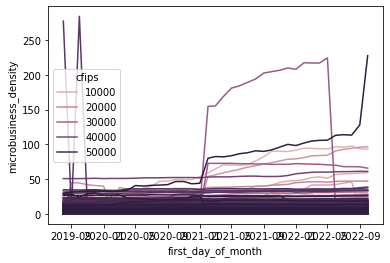

In [46]:
#
sns.lineplot(data = train_base, x = "first_day_of_month", y = "microbusiness_density", hue = "cfips")

# RE:Pre-Processing: After validation

Based on observations made, 
1. Census data lacks information for 2022, and needs to be generated
2. Training data is not lacking any essential information

Steps:
1. Project/impute the 2022 census data into the dataset
2. Join the training set and the census data

#### Projecting census data

We can potentially use a slew of techniques here

# Notes for later

1. No 2022 census data. May need to project to get estimates

### Merge the inputs provided

We will join the 2 datasets together on "cfips" and "year" columns.

In [153]:
train_base

,row_id,cfips,year,month,first_day_of_month,county,state,active,microbusiness_density
0,1001_2019-08-01,1001,2019,8,2019-08-01,Autauga County,Alabama,1249,3.007682
1,1001_2019-09-01,1001,2019,9,2019-09-01,Autauga County,Alabama,1198,2.884870
2,1001_2019-10-01,1001,2019,10,2019-10-01,Autauga County,Alabama,1269,3.055843
3,1001_2019-11-01,1001,2019,11,2019-11-01,Autauga County,Alabama,1243,2.993233
4,1001_2019-12-01,1001,2019,12,2019-12-01,Autauga County,Alabama,1243,2.993233
...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022,6,2022-06-01,Weston County,Wyoming,101,1.803249
122261,56045_2022-07-01,56045,2022,7,2022-07-01,Weston County,Wyoming,101,1.803249
122262,56045_2022-08-01,56045,2022,8,2022-08-01,Weston County,Wyoming,100,1.785395
122263,56045_2022-09-01,56045,2022,9,2022-09-01,Weston County,Wyoming,100,1.785395


In [154]:
train_data = train_base.merge(thin_census_data, on = ["cfips","year"], how = 'left')

# Using merge statament to avoid juggling index of dataframes
# We will validate the row count, which should not increase if join is correct
train_data = pd.merge(left = train_base,right = thin_census_data,how = 'left',on = ['cfips','year'])
train_data

,row_id,cfips,year,month,first_day_of_month,county,state,active,microbusiness_density,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001_2019-08-01,1001,2019,8,2019-08-01,Autauga County,Alabama,1249,3.007682,80.6,16.1,2.3,0.7,58731.0
1,1001_2019-09-01,1001,2019,9,2019-09-01,Autauga County,Alabama,1198,2.884870,80.6,16.1,2.3,0.7,58731.0
2,1001_2019-10-01,1001,2019,10,2019-10-01,Autauga County,Alabama,1269,3.055843,80.6,16.1,2.3,0.7,58731.0
3,1001_2019-11-01,1001,2019,11,2019-11-01,Autauga County,Alabama,1243,2.993233,80.6,16.1,2.3,0.7,58731.0
4,1001_2019-12-01,1001,2019,12,2019-12-01,Autauga County,Alabama,1243,2.993233,80.6,16.1,2.3,0.7,58731.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022,6,2022-06-01,Weston County,Wyoming,101,1.803249,NaN,NaN,NaN,NaN,NaN
122261,56045_2022-07-01,56045,2022,7,2022-07-01,Weston County,Wyoming,101,1.803249,NaN,NaN,NaN,NaN,NaN
122262,56045_2022-08-01,56045,2022,8,2022-08-01,Weston County,Wyoming,100,1.785395,NaN,NaN,NaN,NaN,NaN
122263,56045_2022-09-01,56045,2022,9,2022-09-01,Weston County,Wyoming,100,1.785395,NaN,NaN,NaN,NaN,NaN
